<a href="https://colab.research.google.com/github/ilakiya1904/TP53-Mutation-Prediction/blob/main/TP53_Mutation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

15-Jul-2025 06:11:21 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
15-Jul-2025 06:11:21 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
15-Jul-2025 06:11:21 INFO GEOparse - Parsing ./GSE2034_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE2034_family.soft.gz: 
15-Jul-2025 06:11:21 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
15-Jul-2025 06:11:21 DEBUG GEOparse - SERIES: GSE2034
DEBUG:GEOparse:SERIES: GSE2034
15-Jul-2025 06:11:22 DEBUG GEOparse - PLATFORM: GPL96
DEBUG:GEOparse:PLATFORM: GPL96
15-Jul-2025 06:11:23 DEBUG GEOparse - SAMPLE: GSM36777
DEBUG:GEOparse:SAMPLE: GSM36777
15-Jul-2025 06:11:23 DEBUG GEOparse - SAMPLE: GSM36778
DEBUG:GEOparse:SAMPLE: GSM36778
15-Jul-2025 06:11:23 DEBUG GEOparse - SAMPLE: GSM36779
DEBUG:GEOparse:SAMPLE: GSM36779
15-Jul-2025 06:11:23 DEBUG GEOparse - SAMPLE: GSM36780
DEBUG:GEOparse:SAMPLE: GSM36780
15-Jul-2025


🔍 Random Forest Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        29
           1       0.69      0.69      0.69        29

    accuracy                           0.69        58
   macro avg       0.69      0.69      0.69        58
weighted avg       0.69      0.69      0.69        58



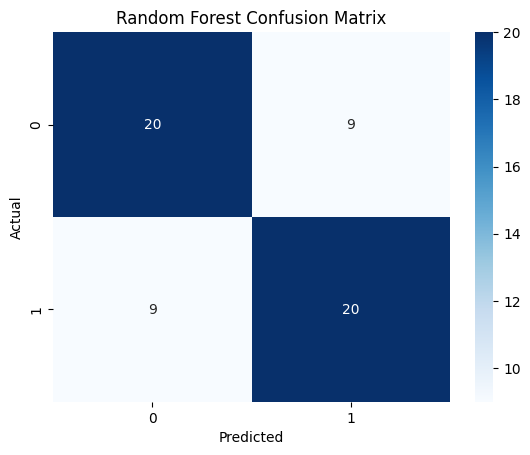


🔍 Logistic Regression Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.63      0.59      0.61        29
           1       0.61      0.66      0.63        29

    accuracy                           0.62        58
   macro avg       0.62      0.62      0.62        58
weighted avg       0.62      0.62      0.62        58



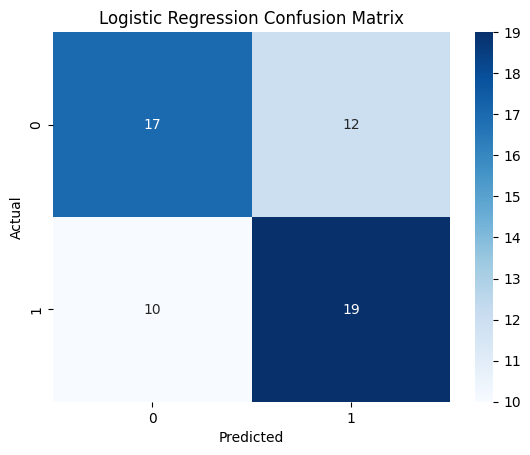


🔍 SVM Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.74      0.59      0.65        29
           1       0.66      0.79      0.72        29

    accuracy                           0.69        58
   macro avg       0.70      0.69      0.69        58
weighted avg       0.70      0.69      0.69        58



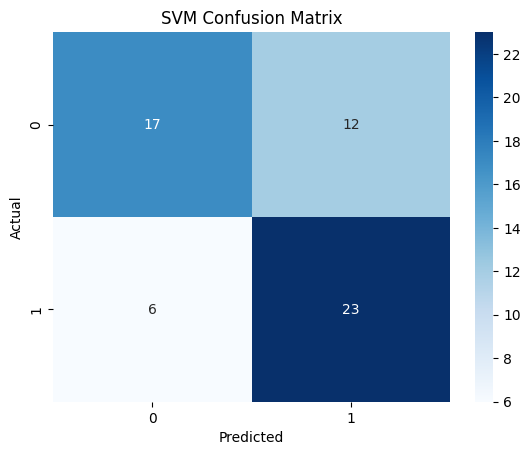

/tmp/ipython-input-6-1307709490.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")
/tmp/ipython-input-6-1307709490.py:80: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


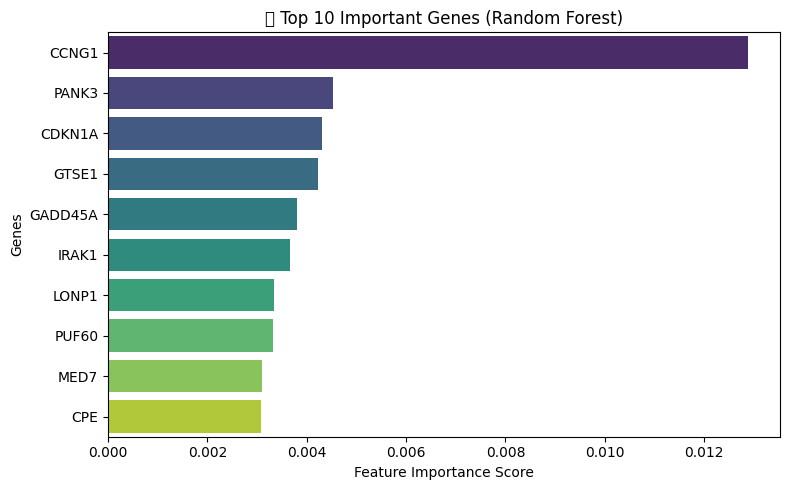

In [6]:
# Step 1: Install and Import Required Libraries
!pip install GEOparse --quiet

import GEOparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 2: Download the GSE2034 Series Matrix from GEO
gse = GEOparse.get_GEO("GSE2034", destdir=".")

# Step 3: Extract expression data (VALUE field)
expression_data = gse.pivot_samples("VALUE")
expression_data = expression_data.T  # Rows = samples, Columns = probes

# Step 4: Load GPL96 Platform to map probes to gene symbols
gpl = GEOparse.get_GEO("GPL96", destdir=".")
probe_map = gpl.table[["ID", "Gene Symbol"]].dropna()
probe_map = probe_map.set_index("ID")

# Step 5: Map probes to gene symbols and average duplicate genes
expression_data = expression_data.T.join(probe_map)
expression_data = expression_data.dropna(subset=["Gene Symbol"])
expression_data = expression_data.groupby("Gene Symbol").mean().T

# Step 6: Define TP53-related signature genes
signature_genes = ["TP53", "MDM2", "CDKN1A", "BAX", "GADD45A", "CCNG1"]

# Step 7: Calculate TP53 signature score and binary mutation-like labels
score = expression_data[signature_genes].mean(axis=1)
expression_data["TP53_signature_score"] = score
expression_data["TP53_status"] = (score > score.median()).astype(int)

# Step 8: ML Modeling with Reproducibility
X = expression_data.drop(columns=["TP53_signature_score", "TP53_status"])
y = expression_data["TP53_status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Step 9: Evaluate Models
def evaluate(model, name):
    y_pred = model.predict(X_test)
    print(f"\n🔍 {name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate(rf, "Random Forest")
evaluate(lr, "Logistic Regression")
evaluate(svm, "SVM")

# Step 10: Feature Importance (Random Forest)
importances = rf.feature_importances_
features = X.columns
feat_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_df = feat_df.sort_values("Importance", ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")
plt.title("🔍 Top 10 Important Genes (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Genes")
plt.tight_layout()
plt.show()
